## Explainable AI in Lending Workshop

1. Building a simple credit risk model using machine learning (~5 mins)
2. **Explainability Method a:** Explaining the model using model coefficients (~2 mins)
3. **Explainability Method b:** Using Shapley values to explain predictions (~5 mins)
4. **Explainability Method c:** Counterfactual explainability (~5 mins)
5. Putting everything together!

In [1]:
# imports

import numpy as np
np.random.seed(42)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import statsmodels.api as sm

import xgboost as xgb

import shap
shap.initjs()

import dice_ml

### 1. Building a simple credit risk model using machine learning

The following features have been taken from [Kaggle - GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit/data) and massaged it.

Number | Variable Name | Description | Type
--- | --- | --- | ---
1 | **RevolvingUtilizationOfUnsecuredLines** | Total balance on credit cards and personal lines of credit except real estate and no installment debt | *real (percentage)*
2 | **age** | Age of borrower in years | *int*
3 | **NumberOfTime30-59DaysPastDueNotWorse** | Number of times borrower has been 30-59 days past due but no worse in the last 2 years | *int*
4 | **DebtRatio** | Monthly debt payments, alimony, living costs divided by monthy gross income | *real (percentage)*
5 | **MonthlyIncome** | Monthly income | *real*
6 | **NumberOfOpenCreditLinesAndLoans** | Number of open loans (installments like car loans or mortgages) and lines of credit (e.g. credit cards) | *int*
7 | **NumberOfTimes90DaysLate** | Number of times borrower has been 90 days or more past due | *int*
8 | **NumberRealEstateLoansOrLines** | Number of mortgage and real estate loans including home equity lines of credit | *int*
9 | **NumberOfTime60-89DaysPastDueNotWorse** | Number of times borrower has been 60-89 days past due but no worse in the last 2 years | *int*
10 | **NumberOfDependents** | Number of dependents in family excluding themselves (spouse, children etc.) | *int*

I have added the following features:

Number | Variable Name | Description | Type
--- | --- | --- | ---
11 | **ApplicationApproved** _(target)_ | Borrower's credit card application approved | *int (y (1)/ n (0))*
12 | **Avg30DayGamblingSpend** | Average monthly spend on gambling activities | *real*
13 | **Avg30DayCashWithdrawals** | Average monthly cash withdrawals | *real*
14 | **NumberOfDirectDebitsFailingLast30Days** | Number of Direct Debits failed in the last 30 days | *int*
15 | **CreditCardUsedForUtilities** | Whether a credit card was used for utilities payments | *bool*
16 | **Avg30DayBenefitsReceived** | How much universal credit the borrower receives | *real*

In [2]:
df = pd.read_csv('../data/credit_card_approval_features_and_target.csv', index_col=[0])

In [3]:
df.head(5)

,ApplicationApproved,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Avg30DayGamblingSpend,Avg30DayCashWithdrawals,NumberOfDirectDebitsFailingLast30Days,CreditCardUsedForUtilities,Avg30DayBenefitsReceived
0,1,1.000000,30,98,3.000000,NaN,0,98,0,98,2,65.393343,377.913064,1,0,0.000000
1,1,1.000000,21,98,0.000000,0.0,0,98,0,98,0,0.000000,0.000000,4,0,0.000000
2,0,0.473755,54,3,0.153641,6000.0,6,6,0,2,0,71.670856,39.194422,5,1,559.767075
3,1,1.000000,57,1,0.298093,5400.0,4,1,1,1,0,78.919051,0.000000,2,1,555.043133
4,1,1.000000,31,98,0.000000,NaN,0,98,0,98,0,57.262684,108.691813,0,0,0.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ApplicationApproved                    5000 non-null   int64  
 1   RevolvingUtilizationOfUnsecuredLines   5000 non-null   float64
 2   age                                    5000 non-null   int64  
 3   NumberOfTime30-59DaysPastDueNotWorse   5000 non-null   int64  
 4   DebtRatio                              5000 non-null   float64
 5   MonthlyIncome                          4087 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans        5000 non-null   int64  
 7   NumberOfTimes90DaysLate                5000 non-null   int64  
 8   NumberRealEstateLoansOrLines           5000 non-null   int64  
 9   NumberOfTime60-89DaysPastDueNotWorse   5000 non-null   int64  
 10  NumberOfDependents                     5000 non-null   int64  
 11  Avg3

We see that we have a range of numerical features - either integer or floats for features. The target is `ApplicationApproved`. We see that `MonthlyIncome` has `null` values - which we can fill in and improve upon.

In [5]:
df.describe()

,ApplicationApproved,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Avg30DayGamblingSpend,Avg30DayCashWithdrawals,NumberOfDirectDebitsFailingLast30Days,CreditCardUsedForUtilities,Avg30DayBenefitsReceived
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4087.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.615200,0.694375,46.639800,6.452200,0.831125,5867.601419,7.331200,5.954800,0.826000,6.638800,0.898600,72.615977,68.121592,2.210400,0.499200,201.522955
std,0.486597,0.417002,13.300625,21.874986,1.042860,13264.569532,5.119839,21.980232,1.073664,21.795021,1.197583,19.283111,72.979800,1.552486,0.500049,261.379671
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.330972,36.000000,0.000000,0.171504,3000.000000,4.000000,0.000000,0.000000,1.000000,0.000000,62.432178,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.836541,47.000000,1.000000,0.375744,4500.000000,7.000000,0.000000,1.000000,1.000000,0.000000,72.760152,47.381779,2.000000,0.000000,0.000000
75%,1.000000,1.000000,55.000000,2.000000,0.806229,6756.500000,10.000000,1.000000,1.000000,2.000000,2.000000,84.592203,115.887502,4.000000,1.000000,529.577198
max,1.000000,2.000000,95.000000,98.000000,3.000000,649587.000000,35.000000,98.000000,14.000000,98.000000,7.000000,134.958299,377.913064,5.000000,1.000000,596.959471


A few different ways to view and understand features. 

<Axes: ylabel='age'>

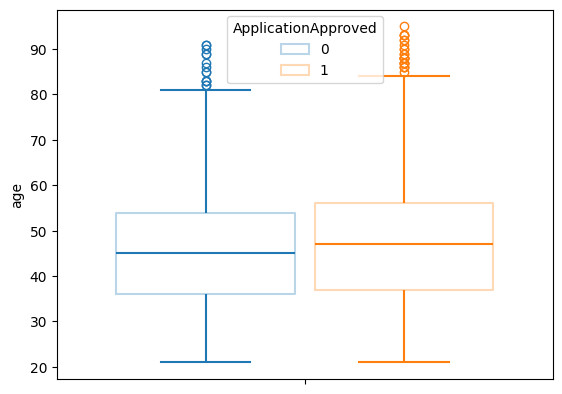

In [6]:
sns.boxplot(df, y='age', hue="ApplicationApproved", fill=False, gap=.1, boxprops=dict(alpha=.3))

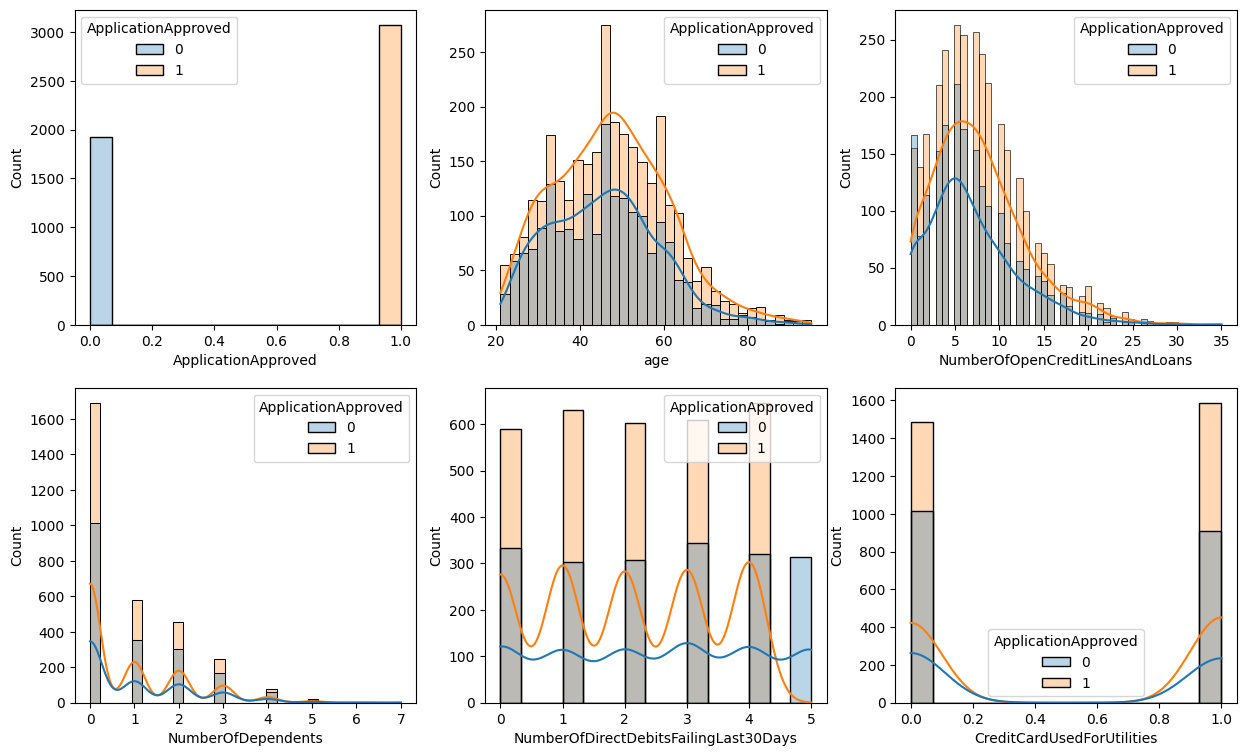

In [7]:
# Update as needed
n_rows = 2
n_cols = 3

# integer columns to plot histograms to view pdfs
cols = ['ApplicationApproved', 'age', 'NumberOfOpenCreditLinesAndLoans', 
        'NumberOfDependents', 'NumberOfDirectDebitsFailingLast30Days', 'CreditCardUsedForUtilities']

# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 9))
for i, column in enumerate(cols):
    sns.histplot(df, x=column, hue='ApplicationApproved', ax=axes[i // n_cols, i % n_cols], kde=True, alpha=0.3)

All subplots seem to have very similar distributions when separated by whether an application is approved. Focusing on figure 5, depicting the histogram of `NumberOfDirectDebitsFailingLast30Days` we see that if someone has 5 failed DDs, their application has been denied. This is an indicator that an algorithm should pick up on.

**Task:** Explore other features. Hint: look at correlations, pairwise relationships, combination of features.

**Goal:** Familiarize yourself with the dataset.

Dealing with NaNs in `MonthlyIncome`.

In [8]:
df['MonthlyIncome'].describe()

count      4087.000000
mean       5867.601419
std       13264.569532
min           0.000000
25%        3000.000000
50%        4500.000000
75%        6756.500000
max      649587.000000
Name: MonthlyIncome, dtype: float64

In [9]:
# filter those big outliers (for simplicity) and keep nans

df = df[(df['MonthlyIncome'] < df['MonthlyIncome'].quantile(0.995)) | (pd.isna(df['MonthlyIncome']))]

<Axes: xlabel='MonthlyIncome', ylabel='Count'>

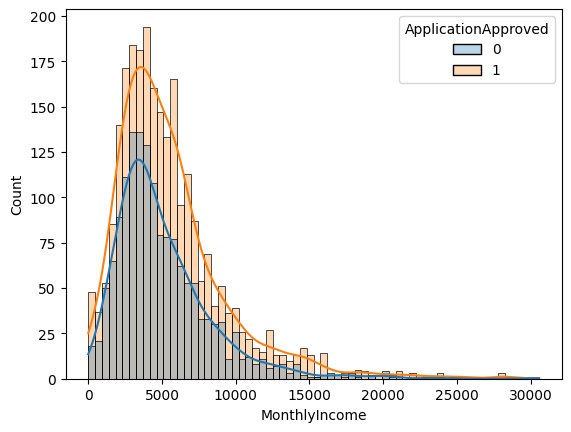

In [10]:
sns.histplot(df, x='MonthlyIncome', hue='ApplicationApproved', kde=True, alpha=0.3)

In [11]:
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(np.nanmedian(df['MonthlyIncome']))

In [12]:
df['MonthlyIncome'].describe()

count     4979.000000
mean      5210.034545
std       3350.001499
min          0.000000
25%       3300.000000
50%       4500.000000
75%       6100.000000
max      30566.000000
Name: MonthlyIncome, dtype: float64

**Brainstorm:** What are ways one can estimate a person's income? 

Hint: Payslips (self-reporting).. and more. What if they have multiple sources of income? What is considered income?

**Goal:** Income plays an important role in underwriting. Accurate income estimation is important!

Using ChatGPT, I've written code to fit a simple LogisticRegression model on this dataset.

In [13]:
# Create sklearn pipeline
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'Avg30DayGamblingSpend',
       'Avg30DayCashWithdrawals', 'NumberOfDirectDebitsFailingLast30Days',
       'CreditCardUsedForUtilities', 'Avg30DayBenefitsReceived']

target = 'ApplicationApproved'

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3)

# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

Again ChatGPT to the rescue.

In [14]:
# Predict on training set
y_train_pred = pipeline.predict(X_train)

print(classification_report(y_train, y_train_pred, target_names=['Denied', 'Approved']))

# Predict on test set
y_test_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_test_pred, target_names=['Denied', 'Approved']))

              precision    recall  f1-score   support

      Denied       0.64      0.47      0.54      1342
    Approved       0.72      0.83      0.77      2143

    accuracy                           0.69      3485
   macro avg       0.68      0.65      0.66      3485
weighted avg       0.69      0.69      0.68      3485

              precision    recall  f1-score   support

      Denied       0.57      0.44      0.50       576
    Approved       0.69      0.80      0.74       918

    accuracy                           0.66      1494
   macro avg       0.63      0.62      0.62      1494
weighted avg       0.65      0.66      0.65      1494



**Task:** Beat this model!

**Goal:** Explainability vs. Performance - this has always been viewed as a tradeoff. But will you use a model if it is not performant, but explainable? What about vice-vera?

In [15]:
# bring your own model

### 2. Explainability Method a: Model Coefficients

In [16]:
# Get coefficients using statsmodels
X_train_scaled = pipeline.named_steps['standard_scaler'].transform(X_train)
X_train_scaled_constant = sm.add_constant(X_train_scaled)  # Add constant for intercept
logit_model = sm.Logit(y_train, X_train_scaled_constant)
result = logit_model.fit()

# Print the summary of the logistic regression model
print(result.summary(xname=['constant'] + features))

Optimization terminated successfully.
         Current function value: 0.580916
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     ApplicationApproved   No. Observations:                 3485
Model:                           Logit   Df Residuals:                     3469
Method:                            MLE   Df Model:                           15
Date:                 Sat, 09 Mar 2024   Pseudo R-squ.:                  0.1284
Time:                         00:36:17   Log-Likelihood:                -2024.5
converged:                        True   LL-Null:                       -2322.7
Covariance Type:             nonrobust   LLR p-value:                1.974e-117
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
constant                                  0.56

For a logistic regression model, the target i.e. `ApplicationApproved` is modelled as a *logit*. A logit is defined as the $log(odds)$ where $odds$ is the ratio, $\frac{P(ApplicationApproved = 1)}{P(ApplicationApproved = 0)}$. 

Here we can clearly see in the case of unit decrease in `Avg30DayGamblingSpend`, results in a 63.8% ($e^{0.4939}$) - normalized to a percentage, increase in the odds of application approval! The sign dictates the direction in which `Avg30DayGamblingSpend` affects `ApplicationApproved`.

**Task:** How can a borrower increase their chances of being accepted according to this model? 

**Goal:** Would this pass the mom test i.e. would your mom be able to understand how to maximise chances of approval? 

A logistic regression is a highly interpretable model that allows someone to clearly attribute changes in features to the change in outcome i.e. `ApplicationApproved`. 

**Open Questions:** 
1. (alternative model) How do you explain models that are not logistic regression based? Trees/XGBoost/LightGBM etc (these would be performing better in most cases!)
2. (actionable recourse) A layperson understands how to improve chances of being accepted - decrease gambling spend! But by exactly how much? How much do I need to change/perturb my features, so `ApplicationApproved` moves from 0 to 1?
3. (causality) Does a higher monthly income __cause__ someone's chances of credit card approval to increase?


### 3. Explainability Method b: Shapley Values

(alternative model) How do you explain models that are not logistic regression based? Trees/XGBoost/LightGBM etc (these would be performing better in most cases!)

In [17]:
# Create xgboost pipeline
pipeline_xgboost = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('xgboost', xgb.XGBClassifier())
])

# Fit the pipeline
pipeline_xgboost.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [18]:
# Predict on training set
y_train_pred = pipeline_xgboost.predict(X_train)
y_train_pred_prob = pipeline_xgboost.predict_proba(X_train)

print(classification_report(y_train, y_train_pred, target_names=['Denied', 'Approved']))

# Predict on test set
y_test_pred = pipeline_xgboost.predict(X_test)

print(classification_report(y_test, y_test_pred, target_names=['Denied', 'Approved']))

              precision    recall  f1-score   support

      Denied       1.00      0.99      0.99      1342
    Approved       0.99      1.00      1.00      2143

    accuracy                           0.99      3485
   macro avg       1.00      0.99      0.99      3485
weighted avg       0.99      0.99      0.99      3485

              precision    recall  f1-score   support

      Denied       0.67      0.66      0.66       576
    Approved       0.79      0.80      0.79       918

    accuracy                           0.74      1494
   macro avg       0.73      0.73      0.73      1494
weighted avg       0.74      0.74      0.74      1494



Accuracy has increased from 66% to 74% in the test set! This is a 12.5% increase in accuracy, just by swapping the model.

<Axes: xlabel='feature_importances', ylabel='feature_names'>

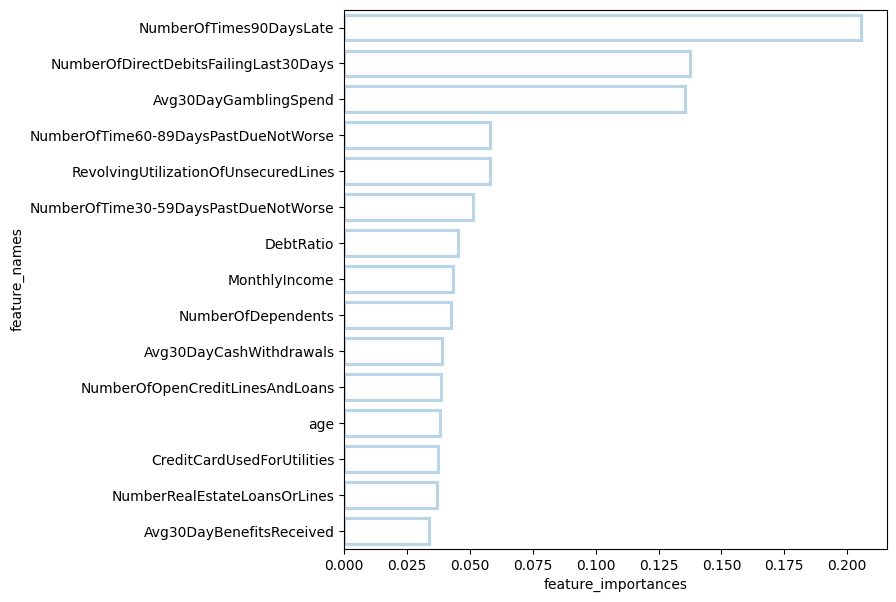

In [19]:
xgboost_trained_model = pipeline_xgboost.named_steps['xgboost']
feature_importances = xgboost_trained_model.feature_importances_
feature_importances_df = pd.DataFrame()
feature_importances_df['feature_names'] = features
feature_importances_df['feature_importances'] = feature_importances
feature_importances_df = feature_importances_df.sort_values(by='feature_importances', ascending=False)

fig, axes = plt.subplots(figsize=(7, 7))
sns.barplot(data=feature_importances_df, y='feature_names', x='feature_importances', gap=0.1, fill=False, alpha=0.3)

But do I increase or decreasing my gambling spend? Has the model learnt the correct relationship?

In [30]:
# fig, ax = plt.subplots(figsize=(50, 50))
# xgboost_trained_model.get_booster().feature_names = features
# xgb.plot_tree(xgboost_trained_model, rankdir='LR', ax=ax)

# However, this is very detailed and difficult to interpret! 

In [21]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
explainer = shap.TreeExplainer(xgboost_trained_model, X_train_scaled_df, model_output='probability')
shap_values = explainer(X_train_scaled_df)

Lets look at a particular borrower, Application 3.

In [22]:
print("Actual Label:", y_train.iloc[2])
print("Predicted Label:", y_train.iloc[2])
print("Predicted probability of denial:", f"{100*y_train_pred_prob[2][0]:.3f}%")
print("Predicted probability of acceptance:", f"{100*y_train_pred_prob[2][1]:.3f}%")
print("Log odds:", f"{np.log(y_train_pred_prob[2][1]/y_train_pred_prob[2][0]):.3f}")

Actual Label: 1
Predicted Label: 1
Predicted probability of denial: 5.959%
Predicted probability of acceptance: 94.041%
Log odds: 2.759


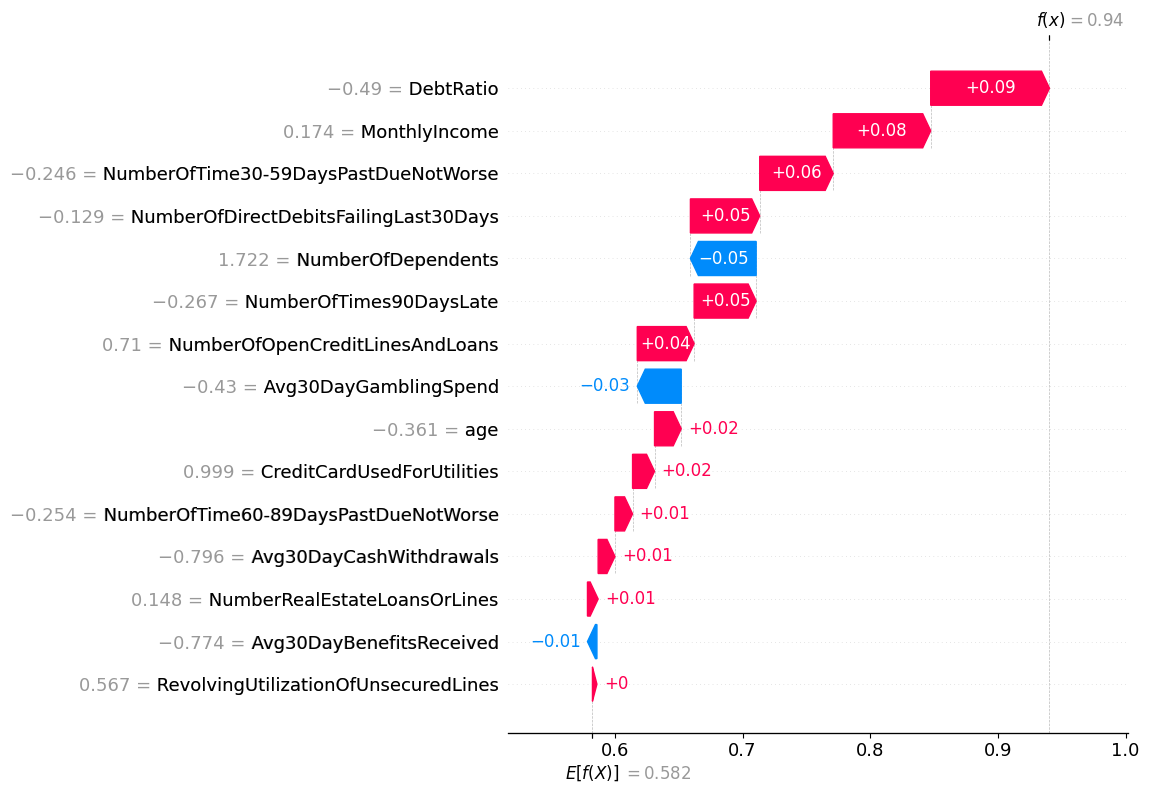

In [23]:
# visualize the prediction's explanation
shap.plots.waterfall(shap_values[2], max_display=20)

The probability of being accepted can be broken down into its constituents - enabling explanations for how much each feature contributes to the probability of being accepted. E.g. a good `DebtRatio` contributed to 9% of probability of being accepted.

The log-odds value that XGBoost predicts, can be broken down into exact components that add up to it.

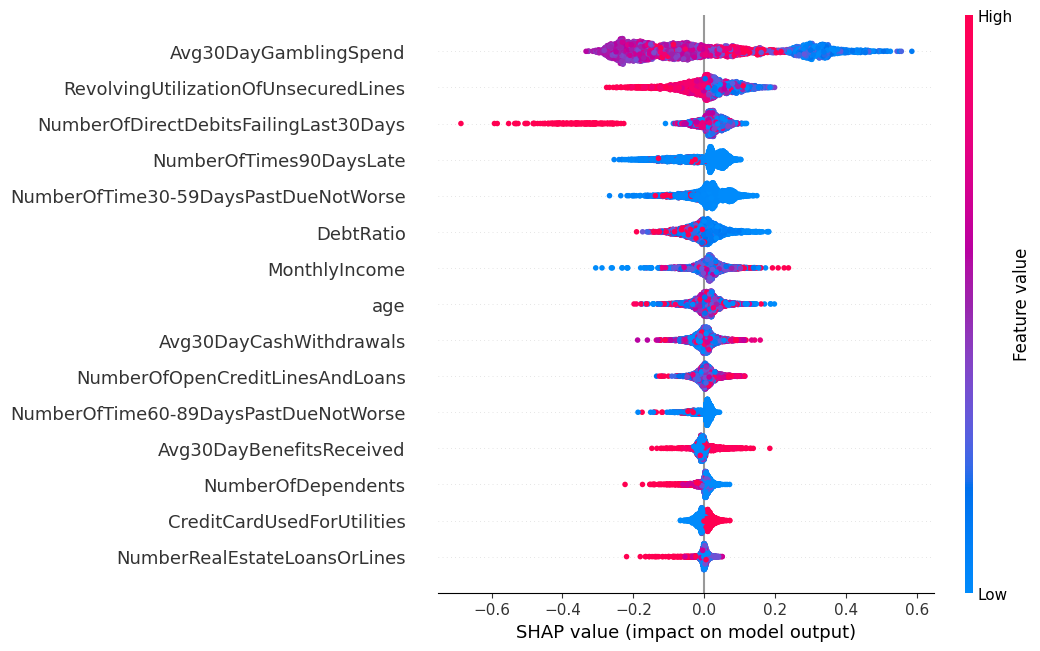

In [24]:
# visualize shapley values globally across features and samples
shap.plots.beeswarm(shap_values, max_display=20)

Low levels of `Avg30DayGamblingSpend` contributes **positively** to acceptance. Similarly, low amount of `RevolvingUtilizationOfUnsecuredLines` contributes **positively** to acceptance. Are there any counter-intuitive features?

### 4. Explainability Method c: Counterfactual Explanations

(actionable recourse) A layperson understands how to improve chances of being accepted - decrease gambling spend! But by exactly how much? How much do I need to change/perturb my features, so `ApplicationApproved` moves from 0 to 1?

We use [DiCE](https://github.com/interpretml/DiCE) - Diverse Counterfactual Explanations to this.

In [25]:
Xy_train_scaled_df = X_train_scaled_df.copy()
Xy_train_scaled_df['ApplicationApproved'] = y_train.values

d = dice_ml.Data(dataframe=Xy_train_scaled_df,
                 continuous_features=features,
                 outcome_name='ApplicationApproved')

# Pre-trained ML model
m = dice_ml.Model(model=xgboost_trained_model, backend='sklearn')

# DiCE explanation instance
exp = dice_ml.Dice(d, m)

In [26]:
features_to_vary = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',  'Avg30DayGamblingSpend']
permitted_range = {'DebtRatio': [Xy_train_scaled_df['DebtRatio'].quantile(0.10), Xy_train_scaled_df['DebtRatio'].quantile(0.90)],
                  'NumberOfOpenCreditLinesAndLoans': [Xy_train_scaled_df['NumberOfOpenCreditLinesAndLoans'].quantile(0.10),
                                                      Xy_train_scaled_df['NumberOfOpenCreditLinesAndLoans'].quantile(0.90)],
                  'Avg30DayGamblingSpend': [Xy_train_scaled_df['Avg30DayGamblingSpend'].quantile(0.10),
                                                      Xy_train_scaled_df['Avg30DayGamblingSpend'].quantile(0.90)]}

dice_exp = exp.generate_counterfactuals(X_train_scaled_df.iloc[0:1], features_to_vary=features_to_vary, 
                                        permitted_range=permitted_range, total_CFs=10, desired_class="opposite")

# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.67it/s]

Query instance (original outcome : 0)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Avg30DayGamblingSpend,Avg30DayCashWithdrawals,NumberOfDirectDebitsFailingLast30Days,CreditCardUsedForUtilities,Avg30DayBenefitsReceived,ApplicationApproved
0,0.12704,0.389764,-0.105721,-0.582652,1.105049,0.5148,-0.266789,-0.760112,-0.254007,0.898003,-0.216999,2.091572,-0.129138,-1.000861,1.421955,0



Diverse Counterfactual set (new outcome: 1)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Avg30DayGamblingSpend,Avg30DayCashWithdrawals,NumberOfDirectDebitsFailingLast30Days,CreditCardUsedForUtilities,Avg30DayBenefitsReceived,ApplicationApproved
0,-0.856733,0.389764,-0.105721,-0.582652,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,1.113989,2.091572,-0.129138,-1.000861,1.421955,1
1,0.127040,0.389764,-0.105721,-0.582652,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-1.067711,2.091572,-0.129138,-1.000861,1.421955,1
2,0.127040,0.389764,-0.105721,-0.313482,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-1.212352,2.091572,-0.129138,-1.000861,1.421955,1
3,0.127040,0.389764,-0.105721,0.235275,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-0.752833,2.091572,-0.129138,-1.000861,1.421955,1
4,0.127040,0.389764,-0.105721,-0.582652,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-1.224405,2.091572,-0.129138,-1.000861,1.421955,1
5,0.127040,0.389764,-0.105721,-0.582652,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-0.990757,2.091572,-0.129138,-1.000861,1.421955,1
6,0.127040,0.389764,-0.105721,-0.582652,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-1.306182,2.091572,-0.129138,-1.000861,1.421955,1
7,0.127040,0.389764,-0.105721,0.254981,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-0.588287,2.091572,-0.129138,-1.000861,1.421955,1
8,2.142064,0.389764,-0.105721,-0.582652,1.105049,0.514800,-0.266789,-0.760112,-0.254007,0.898003,-0.694017,2.091572,-0.129138,-1.000861,1.421955,1
9,0.127040,0.389764,-0.105721,-0.582652,1.105049,1.092594,-0.266789,-0.760112,-0.254007,0.898003,-0.925025,2.091572,-0.129138,-1.000861,1.421955,1


In [27]:
counterfactuals_df = dice_exp.cf_examples_list[0].final_cfs_df.copy()
counterfactuals_df.drop(columns=['ApplicationApproved'], inplace=True)
counterfactuals_df_rescaled = pd.DataFrame(pipeline_xgboost.named_steps['standard_scaler'].inverse_transform(counterfactuals_df), 
                          columns=counterfactuals_df.columns)

In [28]:
display(X_train.iloc[0:1][features_to_vary])
display(counterfactuals_df_rescaled[features_to_vary])

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,NumberOfOpenCreditLinesAndLoans,Avg30DayGamblingSpend
1155,0.741312,0.216976,10,68.746503


,RevolvingUtilizationOfUnsecuredLines,DebtRatio,NumberOfOpenCreditLinesAndLoans,Avg30DayGamblingSpend
0,0.334477,0.216976,10.000000,94.254310
1,0.741312,0.216976,10.000000,52.442969
2,0.741312,0.494701,10.000000,49.670997
3,0.741312,1.060898,10.000000,58.477479
4,0.741312,0.216976,10.000000,49.439997
5,0.741312,0.216976,10.000000,53.917754
6,0.741312,0.216976,10.000000,47.872780
7,0.741312,1.081230,10.000000,61.630917
8,1.574615,0.216976,10.000000,59.604659
9,0.741312,0.216976,12.966788,55.177487


In [29]:
pipeline_xgboost.predict(counterfactuals_df_rescaled)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

As expected, the model would accept all of these counterfactuals!

Other counterfactual explainability methods can be found at [CARLA-recourse](https://github.com/carla-recourse/CARLA).

How do we trust the counterfactuals produced? Causality is assumed in this case!

(causality) But.. does a higher monthly income __cause__ someone's chances of credit card approval to increase?
This is a separate topic, which is out of scope of this presentation. True counterfactuals require a structual causal model, and counterfactuals then can reliably considered.

### 5. Putting everything together

LLMs can tie all of our analysis together with the following prompt (+ careful prompt engineering!) to answer customer queries, either at the time of application or, decision in principle type of scenario.
```python
messages = [
    {
        "role": "system",
        "content": f"You are a friendly chatbot who works in a bank to help customers. James had his credit card application denied due to {shapley_values}. James can improve his chances of improving his credit card application by changing his features from {original_features} to {counterfactual_features}.",
    },
    {"role": "user", "content": "I am James. Why did my credit card application get rejected? What can I do to ensure it gets approved next time?"},
]
```
This can be implemented using [TinyLlama](https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0) for example or any LLM of your choice. Putting everything together is left as an exercise.

```python

import torch
from transformers import pipeline

pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.bfloat16, device_map="cpu")

# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "",
    },
    {"role": "user", "content": ""},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])
```